In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.spatial.distance import cdist

from scipy import signal
from shapely.geometry import Point, Polygon

figsize = (12,12)

### Model Parameters

In [2]:
R_c = 3e3 # 3 km
KERNEL_EXTENT = 100e3 #100 km

### Download open datasets

In [3]:
#Location of all UK primary and secondary schools
!wget https://www.whatdotheyknow.com/request/312648/response/764882/attach/2/EduBase%20Extract%202016%200005414.zip

#School capacity: academic year 2016 to 2017
!wget https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/689756/SFR07_2018_SCAP_underlying_data.zip

#Local Authority Districts (December 2015) Full Extent Boundaries in Great Britain
!wget http://geoportal1-ons.opendata.arcgis.com/datasets/8edafbe3276d4b56aec60991cbddda50_1.zip
    
#Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland
!wget -O ukmidyearestimates2017finalversion.xls https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2017/ukmidyearestimates2017finalversion.xls

--2019-09-12 16:20:14--  https://www.whatdotheyknow.com/request/312648/response/764882/attach/2/EduBase%20Extract%202016%200005414.zip
Resolving www.whatdotheyknow.com (www.whatdotheyknow.com)... 46.43.39.108
Connecting to www.whatdotheyknow.com (www.whatdotheyknow.com)|46.43.39.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1894856 (1.8M) [application/zip]
Saving to: ‘EduBase Extract 2016 0005414.zip’

EduBase Extract 201 100%[===================>]   1.81M   959KB/s    in 1.9s    

2019-09-12 16:20:17 (959 KB/s) - ‘EduBase Extract 2016 0005414.zip’ saved [1894856/1894856]

--2019-09-12 16:20:17--  https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/689756/SFR07_2018_SCAP_underlying_data.zip
Resolving assets.publishing.service.gov.uk (assets.publishing.service.gov.uk)... 151.101.0.144, 151.101.64.144, 151.101.128.144, ...
Connecting to assets.publishing.service.gov.uk (assets.publishing.service.gov.uk)|151.101.0

In [4]:
!unzip "EduBase Extract 2016 0005414.zip"
!unzip "SFR07_2018_SCAP_underlying_data.zip"
!unzip "8edafbe3276d4b56aec60991cbddda50_1.zip"

Archive:  EduBase Extract 2016 0005414.zip
  inflating: EduBase Extract - 2016-0005414.csv  
Archive:  SFR07_2018_SCAP_underlying_data.zip
  inflating: SCAP_2017_metadata.docx  
  inflating: SCAP_UD1_capacity.xlsx  
  inflating: SCAP_UD2_forecasts.xlsx  
  inflating: SCAP_UD3_s106.xlsx      
  inflating: SCAP_UD4_planned_places.xlsx  
Archive:  8edafbe3276d4b56aec60991cbddda50_1.zip
  inflating: Local_Authority_Districts_December_2015_Full_Extent_Boundaries_in_Great_Britain.xml  
  inflating: Local_Authority_Districts_December_2015_Full_Extent_Boundaries_in_Great_Britain.prj  
  inflating: Local_Authority_Districts_December_2015_Full_Extent_Boundaries_in_Great_Britain.shp  
 extracting: Local_Authority_Districts_December_2015_Full_Extent_Boundaries_in_Great_Britain.cpg  
  inflating: Local_Authority_Districts_December_2015_Full_Extent_Boundaries_in_Great_Britain.dbf  
  inflating: Local_Authority_Districts_December_2015_Full_Extent_Boundaries_in_Great_Britain.shx  


### Functions

In [5]:
def aggregate_by(shapes, agg_level='Country', eps=1):
    """
    Merge shapes based on a defined aggregation level
    """
    agg = shapes.loc[:,[agg_level,"geometry"]].copy()
    agg.loc[:,"geometry"] = agg.loc[:,"geometry"].buffer(0)
    
    agg = agg.dissolve(by=agg_level)
    agg.loc[:,"geometry"] = agg.loc[:,"geometry"].buffer(eps).buffer(-eps)
    return agg

#Kernel used for potential calculation
def kernel_powerlaw(xi, yi, alpha=1, R_c=1):
    x = np.arange(-KERNEL_EXTENT, +KERNEL_EXTENT+land_reso, land_reso)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)
    kernel = np.clip(((R/R_c)+1e-10)**-alpha, a_min=0, a_max=1)
    return kernel


## Loading and preprocessing datasets

In [6]:
uk_shape = gpd.read_file("Local_Authority_Districts_December_2015_Full_Extent_Boundaries_in_Great_Britain.shp")
uk_shape['Country'] = uk_shape.lad15cd.apply(lambda x: x[0])

edu_base = pd.read_csv("EduBase Extract - 2016-0005414.csv", encoding = "latin-1", converters = {"EstablishmentNumber":str,"LA (code)":str})
edu_base["LAEstab"] = edu_base["LA (code)"] + edu_base["EstablishmentNumber"]
geometry = [Point(xy) for xy in zip(edu_base.Easting, edu_base.Northing)]
edu_base = gpd.GeoDataFrame(edu_base, crs={"init":'epsg:27700'}, geometry=geometry)

In [7]:
#Choose a projection
latlon = {"init": "epsg:4326"}
utmzone30 = {"init": "epsg:32630"}

edu_base = edu_base.dropna(subset = ["Easting","Northing"])
edu_base = edu_base.to_crs(latlon)

uk_shape = uk_shape.to_crs(utmzone30)
edu_base = edu_base.to_crs(utmzone30)

In [8]:
#edu_base.head(1)

In [9]:
country = aggregate_by(uk_shape)

In [10]:
bbox_UK = {"lat_min":49, "lat_max": 62, "lon_min": -8, "lon_max":2.2}
bbox = bbox_UK

bboxdf = gpd.GeoDataFrame(gpd.GeoSeries(Polygon([[[bbox["lon" + x], bbox["lat" + y]] 
                                         for x in ["_min", "_max"] 
                                         for y in ["_min","_max"]][i] for i in [0,1,3,2]])),
                  columns=['geometry'])

bboxdf.crs = {'init': 'epsg:4326'}

minx, miny, maxx, maxy = bboxdf.bounds.iloc[0]

land_reso = 0.5e3 # 0.5km

#transform bbox to mercator
bboxdf = bboxdf.to_crs(utmzone30)
minx, miny, maxx, maxy = bboxdf.bounds.iloc[0]

x_edges = np.arange(minx, maxx, land_reso)
y_edges = np.arange(miny, maxy, land_reso)

# get the center of the histogram bins
X_centered, Y_centered = np.meshgrid(x_edges[:-1]+np.diff(x_edges)[0], y_edges[:-1]+np.diff(y_edges)[0])
X, Y = np.meshgrid(x_edges, y_edges)


### Create basemap

In [11]:
def plot_map(barangays, agg, country=None):
    fig, ax = plt.subplots(1, figsize = (20,20), subplot_kw = dict(aspect = 'equal'))
    if country is not None:
        country.plot(ax=ax, color='none', linewidth=1, edgecolor="#cccccc", alpha=1, legend=True, zorder=10)
    ax.set_xlim(xmin=minx, xmax=maxx)
    ax.set_ylim(ymin=miny, ymax=maxy)

    return fig, ax

### Potential calculation

In [12]:
def mapper_function(R_c, df, weight_col = None, normed_kernel = False):
    dataframe = df
    
    x_edges = np.arange(minx, maxx, land_reso)
    y_edges = np.arange(miny, maxy, land_reso)
    
    if weight_col:
        H, y_edges, x_edges = np.histogram2d(dataframe.geometry.y, 
                                         dataframe.geometry.x, 
                                         bins=[y_edges, x_edges],
                                         weights = dataframe.loc[:,weight_col]
                                        )
        
    else:
        H, y_edges, x_edges = np.histogram2d(dataframe.geometry.y, 
                                         dataframe.geometry.x, 
                                         bins=[y_edges, x_edges],
                                        )

    X, Y = np.meshgrid(x_edges, y_edges)
    kernel = kernel_powerlaw(X, Y, alpha=2, R_c = R_c) ### Change to chose another kernel
    
    if normed_kernel:
        kernel = kernel/kernel.sum()
    
    proc = signal.fftconvolve(H, kernel, mode='same')
    
    return proc, H, kernel, X, Y

In [13]:
proc_uk, H,_,_,_ = mapper_function(R_c = R_c, df = edu_base)

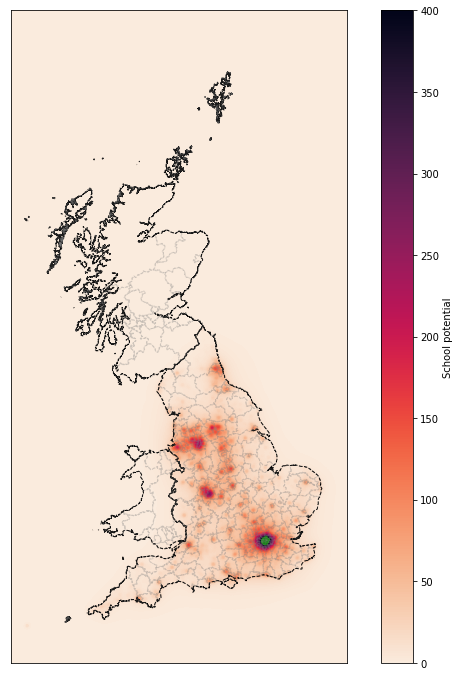

In [14]:
fig, ax = plt.subplots(1, figsize = (12,12), subplot_kw = dict(aspect = 'equal'))
cmap = sns.cm.rocket_r
cmap.set_over('g')
mesh = ax.pcolormesh(X, Y, proc_uk, cmap = cmap, vmax = 400, zorder=0)
cbar = fig.colorbar(mesh)
cbar.set_label("School potential")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
country.plot(ax = ax, color = "None", linestyle = '--', edgecolor = "black", zorder = 10)
uk_shape.plot(ax = ax, color = "None", linestyle="--", alpha = 0.2, edgecolor="gray", zorder = 10)
#edu_base.plot(ax = ax, color = "blue", markersize = 0.5, alpha = 0.1, zorder = 10)

In [15]:
#The number of sole and dual main registered pupils recorded as on roll in the May (summer) school census.
eng_school_capacity = pd.read_excel("SCAP_UD1_capacity.xlsx", \
              converters = {"LAEstab":str, "LA":str, "estab":str, "primary_pa_code":str, "secondary_pa_code":str})

In [16]:
#Combine school location data with school capacity data
school_capacity_location_merged = pd.merge(edu_base, eng_school_capacity, how = "inner", on = "LAEstab")

In [17]:
def get_grid_ind(point_x, point_y, X_grid = X_centered, Y_grid = Y_centered,):
    X_diff = abs(X_centered - point_x)
    Y_diff = abs(Y_centered - point_y)
    
    x_ind = np.unravel_index(np.argmin(X_diff, axis=None), X_diff.shape)[1]
    y_ind = np.unravel_index(np.argmin(Y_diff, axis=None), Y_diff.shape)[0]
    
    return (y_ind, x_ind)

In [18]:
#Get grid indices to sample school potential at relevant points in the map
uk_shape["geom_x"] = uk_shape.geometry.centroid.x
uk_shape["geom_y"] = uk_shape.geometry.centroid.y
uk_shape["centroid_ind"] = uk_shape[["geom_x", "geom_y"]].apply(lambda geom: get_grid_ind(geom[0], geom[1]), axis = 1)

In [19]:
uk_shape["school_potential"] = uk_shape.centroid_ind.apply(lambda x: proc_uk[x])

/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 1000)

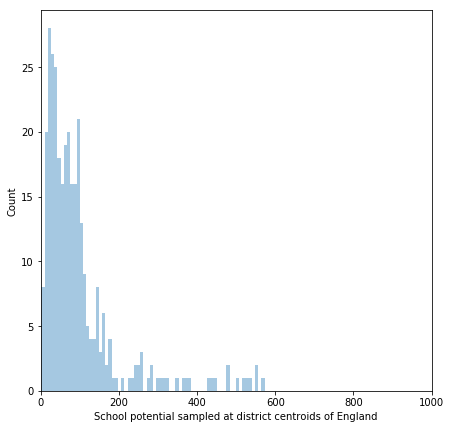

In [20]:
fig, ax = plt.subplots(1,1, figsize = (7,7))
sns.distplot(uk_shape[uk_shape.Country == "E"].school_potential, kde = False, bins = 70, ax = ax)
plt.ylabel("Count")
plt.xlabel("School potential sampled at district centroids of England")
plt.xlim(0,1000)

In [21]:
#Schools that are dropped from EduBase
edu_base[edu_base.LAEstab.isin(list(set(edu_base.LAEstab) - set(school_capacity_location_merged.LAEstab)))].head(5)

,URN,LA (code),LA (name),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),OpenDate,PhaseOfEducation (name),StatutoryLowAge,...,FaxNum,HeadTitle (name),HeadFirstName,HeadLastName,HeadPreferredJobTitle,Region,Easting,Northing,LAEstab,geometry
1,100001,201,City of London,6005,City of London School for Girls,Other Independent School,Open,01/01/1920,Not applicable,7.0,...,2.076383e+09,Mrs,Ena,Harrop,Headteacher,London,532301.0,181746.0,2016005,POINT (701570.1652918009 5711560.961502935)
2,100002,201,City of London,6006,St Paul's Cathedral School,Other Independent School,Open,01/01/1939,Not applicable,4.0,...,2.073297e+09,Mr,Neil,Chippington,Headteacher,London,532160.0,181151.0,2016006,POINT (701437.2813192718 5710963.936814482)
3,100003,201,City of London,6007,City of London School,Other Independent School,Open,01/01/1919,Not applicable,10.0,...,2.073297e+09,Ms,Sarah,Fletcher,Head,London,531981.0,180844.0,2016007,POINT (701262.4515724418 5710654.439017704)
4,100005,202,Camden,1048,Thomas Coram Centre,LA Nursery School,Open,NaN,Nursery,3.0,...,2.075200e+09,Mr,B,Duffy,Headteacher,London,530464.0,182403.0,2021048,POINT (699723.8841160154 5712192.937076709)
5,100006,202,Camden,1100,CCfL Key Stage 4 PRU,Pupil Referral Unit,Open,01/09/1999,Not applicable,14.0,...,NaN,Ms,Elizabeth,Rattue,Headteacher,London,527663.0,185479.0,2021100,POINT (696880.3602803058 5715231.09119926)


In [22]:
uk_population = pd.read_excel("ukmidyearestimates2017finalversion.xls", sheet_name = "MYE2 - All", skiprows = 4)
uk_shape_pop_merge = pd.merge(uk_shape, uk_population, left_on = "lad15cd", right_on = "Code")

#Calculate student age residents of the population from census
uk_shape_pop_merge["primary_school_population"] = uk_shape_pop_merge.loc[:,[3,4,5,6,7,8,9,10,11]].sum(axis = 1)

In [23]:
uk_shape_pop_merge[uk_shape_pop_merge.lad15cd.str.contains("E")].head(1)

,lad15cd,lad15nm,lad15nmw,objectid,st_lengths,st_areasha,geometry,Country,geom_x,geom_y,...,82,83,84,85,86,87,88,89,90,primary_school_population
0,E06000001,Hartlepool,,1,65270.302085,9.844169e+07,"POLYGON ((611511.9212793913 6065690.427294687,...",E,612496.107551,6.059364e+06,...,528.0,458.0,443.0,388.0,335.0,303.0,247.0,196.0,776.0,10486.0


In [24]:
primary_schools = school_capacity_location_merged[school_capacity_location_merged["Main Phase"] == "PRI"]

### Modeled number of students

In [25]:
def students_in_district_weighted(df = primary_schools, shape = uk_shape_pop_merge[uk_shape_pop_merge.lad15cd.str.contains("E")], column = "MAYNOR", alpha=2, R_c=3e3, school_type = "primary"):    
    #print("Done calculating dist matrix.")
    
    if school_type == "primary":
        kernel = np.clip(((cdist(list(zip(df.geometry.x, df.geometry.y)),
      list(zip(shape.geometry.centroid.x, shape.geometry.centroid.y)))/R_c)+1e-10)**-alpha, a_min=0, a_max=1)*(shape.primary_school_population/shape.primary_school_population.sum()).values
    elif school_type == "secondary":
        kernel = np.clip(((cdist(list(zip(df.geometry.x, df.geometry.y)),
      list(zip(shape.geometry.centroid.x, shape.geometry.centroid.y)))/R_c)+1e-10)**-alpha, a_min=0, a_max=1)*(shape.secondary_school_population/shape.secondary_school_population.sum()).values
    else:
        raise ValueError("use keywords: 'primary' or 'secondary' only")
    print("Done calculating potential matrix.")
    return ( ((kernel.T * np.array(df.loc[:, column])) / np.sum(kernel, axis = 1)).T.sum(axis = 0))


In [26]:
primary_schools_students_in_district_weighted = students_in_district_weighted(df = primary_schools, column = "MAYNOR", alpha= 2, R_c=3e3, school_type = "primary")

Done calculating potential matrix.


In [27]:
uk_shape_pop_merge_England = uk_shape_pop_merge[uk_shape_pop_merge.lad15cd.str.contains("E")].copy()
uk_shape_pop_merge_England["primary_pop"] = uk_shape_pop_merge_England.loc[:,[3,4,5,6,7,8,9,10]].sum(axis = 1)
uk_shape_pop_merge_England["primary_students_weighted"] = primary_schools_students_in_district_weighted

### Inverse enrollment pressure

In [28]:
def get_school_district_slots(df_subset, shape, column = "Netcapacity"):
    return df_subset[df_subset.geometry.apply(lambda geom: geom.within(shape))].loc[:,column].sum()

In [29]:
uk_shape_pop_merge_England["primary_school_slots"] = uk_shape_pop_merge_England.geometry.apply(lambda x: get_school_district_slots(primary_schools, x))

In [30]:
uk_shape_pop_merge_England["district_slots_to_primary_students_weighted_ratio"] = uk_shape_pop_merge_England.primary_school_slots/uk_shape_pop_merge_England.primary_students_weighted

Text(0.02,0.5,'Ratio')

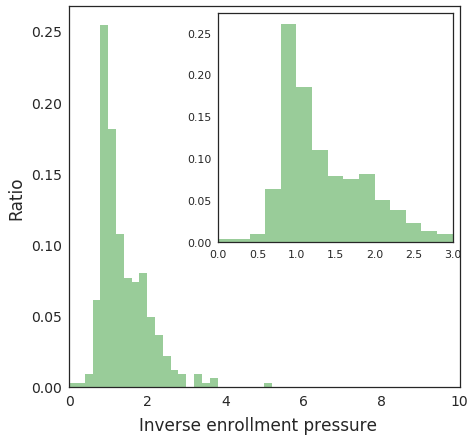

In [53]:
sns.set(font_scale = 1.4, style = "white")
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

xlabel = "Inverse enrollment pressure"
ylabel = "Ratio"

xmax = 10
inset_xmax = 3

step = 0.2

bin_edge = np.arange(0,xmax+step,step)
bin_inset =np.arange(0,inset_xmax+step,step)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize =(7,7))

axin = inset_axes(ax, width="60%", 
                    height="60%", 
                    loc = 1)
#axin.ticklabel_format(style='sci',scilimits=(-3,3), axis = "both", useMathText = True)
axin.tick_params(labelsize=11)
axin.set_xlim(0, inset_xmax)
axin.get_yaxis().set_offset_position('left')

hist1, _ = np.histogram(uk_shape_pop_merge_England.district_slots_to_primary_students_weighted_ratio, bins = bin_edge)
ax.bar(bin_edge[:-1], hist1/hist1.sum(), width = step, color = "#99CC99", align = "edge")

ax.set_xlim([0,10])

hist1, _ = np.histogram(uk_shape_pop_merge_England.district_slots_to_primary_students_weighted_ratio, bins = bin_inset)
axin.bar(bin_inset[:-1], hist1/hist1.sum(), width = step, color = "#99CC99", align = "edge")
axin.set_xlim([0,3])

fig.text(0.5, 0.05, xlabel, ha='center', va='center')
fig.text(0.02, 0.5, ylabel, ha='center', va='center', rotation='vertical')

### Effectivity

In [32]:
uk_shape_pop_merge_England["effectivity_weighted"] = uk_shape_pop_merge_England.primary_students_weighted/uk_shape_pop_merge_England.primary_school_population

Text(0.02,0.5,'Ratio')

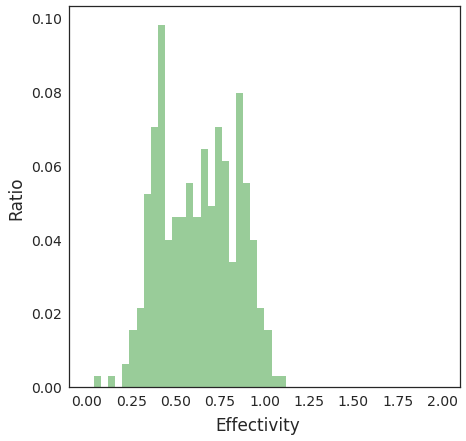

In [52]:
sns.set(font_scale = 1.4, style = "white")

num_bin = 50
bin_edge = np.linspace(0,2,num_bin + 1)

step = bin_edge[1]

xlabel = "Effectivity"
ylabel = "Ratio"

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize =(7,7))

hist1, _ = np.histogram(uk_shape_pop_merge_England.effectivity_weighted, bins = bin_edge)
ax.bar(bin_edge[:-1], hist1/hist1.sum(), width = step, color = "#99CC99", align = "edge")

fig.text(0.5, 0.05, xlabel, ha='center', va='center')
fig.text(0.02, 0.5, ylabel, ha='center', va='center', rotation='vertical')